## Loading Libraries and Dataset

In [1]:
pip install transformers datasets torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments, AdamW, get_scheduler
from tqdm import tqdm
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Load the CoLA dataset
dataset = load_dataset("glue", "cola")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

## Exploratory Data Analysis

In [5]:
# Get basic info about the train, validation, and test datasets
print("Train Dataset Info:")
print(dataset['train'].features)

print("\nValidation Dataset Info:")
print(dataset['validation'].features)

print("\nTest Dataset Info:")
print(dataset['test'].features)

# Get the number of rows in each split
print("\nNumber of rows in each dataset split:")
print(f"Train: {len(dataset['train'])}")
print(f"Validation: {len(dataset['validation'])}")
print(f"Test: {len(dataset['test'])}")


Train Dataset Info:
{'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['unacceptable', 'acceptable'], id=None), 'idx': Value(dtype='int32', id=None)}

Validation Dataset Info:
{'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['unacceptable', 'acceptable'], id=None), 'idx': Value(dtype='int32', id=None)}

Test Dataset Info:
{'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['unacceptable', 'acceptable'], id=None), 'idx': Value(dtype='int32', id=None)}

Number of rows in each dataset split:
Train: 8551
Validation: 1043
Test: 1063


In [6]:
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [7]:
# Convert train dataset to a Pandas DataFrame
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(validation_dataset)
test_df = pd.DataFrame(test_dataset)

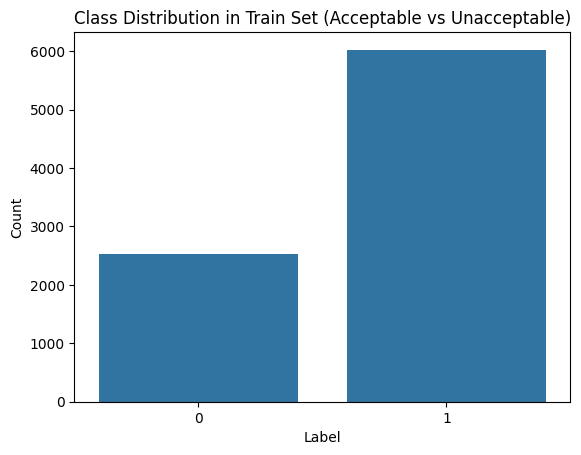

In [8]:

# Plot the class distribution
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Train Set (Acceptable vs Unacceptable)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


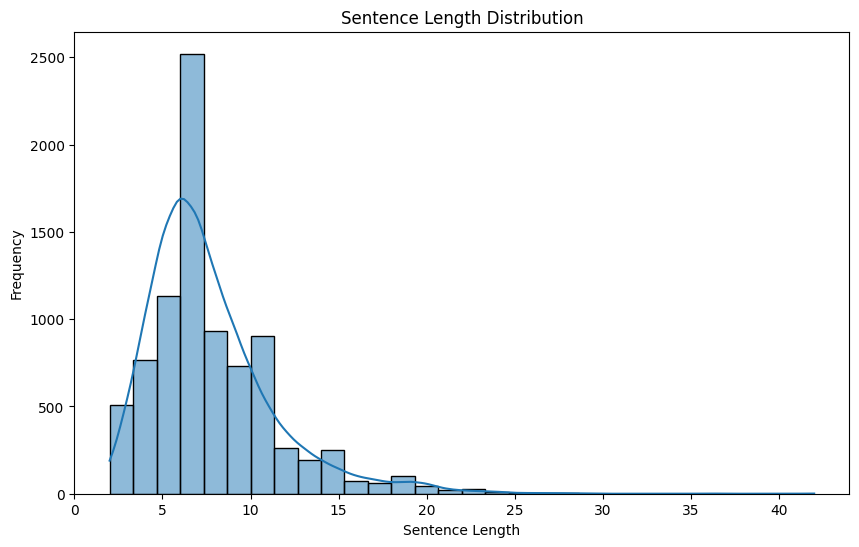

In [9]:
train_df['sentence_length'] = train_df['sentence'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(train_df['sentence_length'], kde=True, bins=30)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()


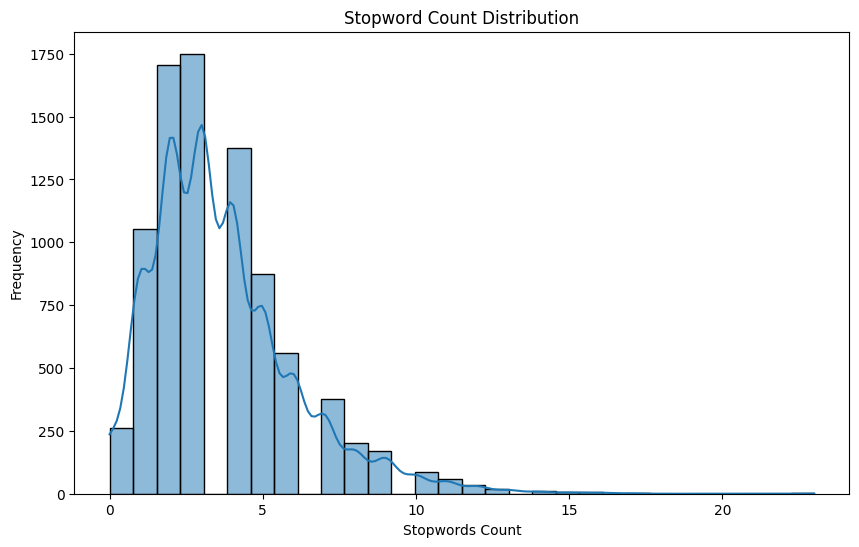

In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

# Tokenize sentences and count stopwords
train_df['stopword_count'] = train_df['sentence'].apply(lambda x: sum(1 for word in word_tokenize(x.lower()) if word in stop_words))
plt.figure(figsize=(10, 6))
sns.histplot(train_df['stopword_count'], kde=True, bins=30)
plt.title('Stopword Count Distribution')
plt.xlabel('Stopwords Count')
plt.ylabel('Frequency')
plt.show()


## Data Cleaning and Tokenization

In [11]:
# # Load stopwords
# stop_words = set(stopwords.words("english"))

# def clean_text(text):
#     # Remove special characters except essential ones
#     text = re.sub(r"[^a-zA-Z0-9.,!?\'\s]", "", text)

#     # Expand contractions (e.g., "don't" -> "do not")
#     contractions = {
#         "can't": "cannot", "won't": "will not", "n't": " not", "'ll": " will", "'ve": " have",
#         "'re": " are", "'d": " would", "'m": " am"
#     }
#     for contraction, expansion in contractions.items():
#         text = text.replace(contraction, expansion)

#     # Remove stopwords
#     text = " ".join([word for word in text.split() if word.lower() not in stop_words])

#     return text


In [12]:
# dataset = dataset.map(lambda x: {"sentence": clean_text(x["sentence"])})


In [13]:
# Load the pre-trained tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [14]:
def preprocess_function(examples):
    return tokenizer(
        examples["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt",
    )

# Tokenizing the train and validation datasets
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

## Evaluating on the baseline model

In [15]:
# Load the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Set the model to evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [17]:
# Get validation dataset
validation_dataset = tokenized_datasets["validation"]

# Get inputs and labels
inputs = validation_dataset['input_ids']
attention_masks = validation_dataset['attention_mask']
labels = validation_dataset['label']

# Prepare data in batches for efficient processing
batch_size = 16
num_batches = len(inputs) // batch_size

all_preds = []
all_labels = []

# Use tqdm to show progress bar for batch processing
with torch.no_grad():
    for i in tqdm(range(num_batches), desc="Processing Batches", unit="batch"):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        input_batch = torch.tensor(inputs[start_idx:end_idx])
        attention_mask_batch = torch.tensor(attention_masks[start_idx:end_idx])

        # Forward pass through the model
        outputs = model(input_batch, attention_mask=attention_mask_batch)
        logits = outputs.logits

        # Get predicted class
        preds = torch.argmax(logits, dim=1).tolist()
        all_preds.extend(preds)
        all_labels.extend(labels[start_idx:end_idx])

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")

# Print evaluation metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nMCC: {mcc:.4f}")
print(f"\nF1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Processing Batches: 100%|██████████| 65/65 [01:53<00:00,  1.74s/batch]


Accuracy: 0.3394

MCC: 0.0252

F1 Score: 0.2325

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.94      0.47       321
           1       0.74      0.07      0.13       719

    accuracy                           0.34      1040
   macro avg       0.52      0.51      0.30      1040
weighted avg       0.60      0.34      0.23      1040



In [18]:
print("True Label Distribution:", np.bincount(all_labels))
print("Predicted Label Distribution:", np.bincount(all_preds))


True Label Distribution: [321 719]
Predicted Label Distribution: [972  68]


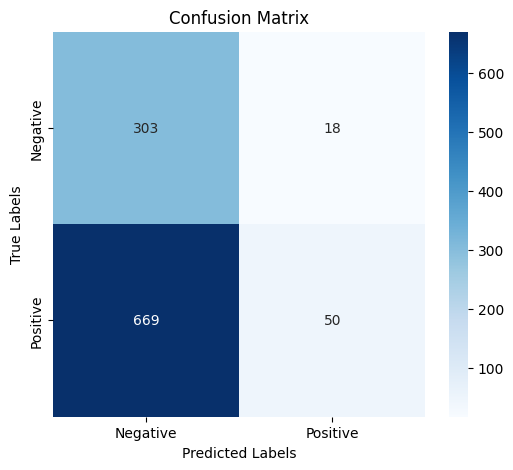

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**As we can see, the baseline model is performing very poorly by labeling almost every sentence as incorrect**

## Using Distilbertforsequenceclassification on the CoLa Dataset

In [20]:
# Load DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
id2label = model.config.id2label  # Dictionary mapping label IDs to names
class_labels = [id2label[i] for i in sorted(id2label.keys())]

In [22]:
# Get training and validation dataset
train_dataset = tokenized_datasets["train"]
validation_dataset = tokenized_datasets["validation"]

In [23]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = validation_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

In [24]:
# Define your device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(batch):
    # Convert list of examples into tensors
    input_ids = torch.tensor([item['input_ids'] for item in batch])  # Convert list to tensor
    attention_mask = torch.tensor([item['attention_mask'] for item in batch])  # Convert list to tensor
    labels = torch.tensor([item['label'] for item in batch])  # Convert list to tensor

    # Return a dictionary
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': labels
    }

# Update DataLoader with custom collate function
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=16, collate_fn=collate_fn)
val_dataloader = DataLoader(validation_dataset, batch_size=16, collate_fn=collate_fn)


In [25]:
# Define optimizer, scheduler, and device
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Training
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        loop.set_postfix(loss=loss.item())


Epoch 5: 100%|██████████| 535/535 [01:32<00:00,  5.79it/s, loss=0.0451]


In [26]:
# Set the model to evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [27]:
# Prepare data in batches for evaluation
all_preds = []
all_labels = []


# Disable gradient computation for evaluation
with torch.no_grad():
    # Loop through the validation data in batches
    for batch in tqdm(val_dataloader, desc="Evaluating", unit="batch"):
        # Move data to the appropriate device (CPU or GPU)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Get predicted class (index of the highest logit)
        preds = torch.argmax(logits, dim=1).tolist()
        labels = batch['label'].tolist()

        # Store predictions and true labels for metric calculation
        all_preds.extend(preds)
        all_labels.extend(labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate MCC
mcc = matthews_corrcoef(all_labels, all_preds)

# Calculate f1_score
f1 = f1_score(all_labels, all_preds, average="weighted")

# Print evaluation metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"\nMCC: {mcc:.4f}")
print(f"\nF1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Evaluating: 100%|██████████| 66/66 [00:03<00:00, 17.58batch/s]



Accuracy: 0.7939

MCC: 0.4844

F1 Score: 0.7791

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.49      0.59       322
           1       0.80      0.93      0.86       721

    accuracy                           0.79      1043
   macro avg       0.78      0.71      0.73      1043
weighted avg       0.79      0.79      0.78      1043



In [28]:
print("True Label Distribution:", np.bincount(all_labels))
print("Predicted Label Distribution:", np.bincount(all_preds))

True Label Distribution: [322 721]
Predicted Label Distribution: [207 836]


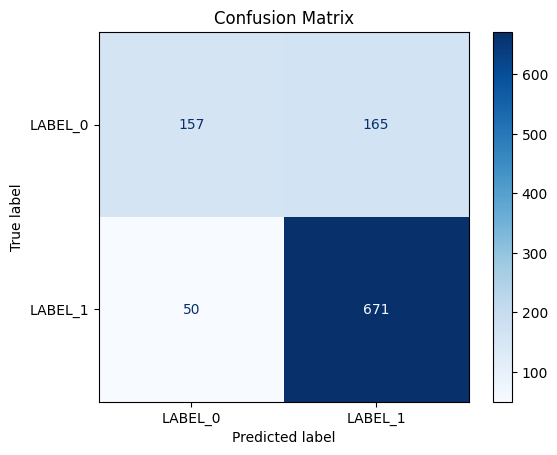

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")

# Add title and display
plt.title("Confusion Matrix")
plt.show()


**Just re-training it on the Cola Dataset, we improved the Accuracy from 0.34 to 0.79, MCC from 0.02 to 0.48 and F1 score from 0.25 to 0.78**

## Fine tuning the baseline distilbert using additional layers

In [30]:
# Get training and validation dataset
train_dataset = tokenized_datasets["train"]
validation_dataset = tokenized_datasets["validation"]

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = validation_dataset.map(preprocess_function, batched=True)

In [31]:
# Define your device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(batch):
    # Convert list of examples into tensors
    input_ids = torch.tensor([item['input_ids'] for item in batch])  # Convert list to tensor
    attention_mask = torch.tensor([item['attention_mask'] for item in batch])  # Convert list to tensor
    labels = torch.tensor([item['label'] for item in batch])  # Convert list to tensor

    # Return a dictionary
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Update DataLoader with custom collate function
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=16, collate_fn=collate_fn)
val_dataloader = DataLoader(validation_dataset, batch_size=16, collate_fn=collate_fn)

In [50]:

# Define the custom model

class EnhancedDistilBertClassifier(nn.Module):
    def __init__(self, num_labels=2):
        super(EnhancedDistilBertClassifier, self).__init__()
        # Initialize the base DistilBERT model
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Enhanced classification head
        self.pre_classifier = nn.Linear(self.bert.config.hidden_size, 512)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.hidden_layer1 = nn.Linear(512, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.hidden_layer2 = nn.Linear(256, 128)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)

        self.classifier = nn.Linear(128, num_labels)

    def forward(self, input_ids, attention_mask):
        # Step 1: Pass input through DistilBERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Step 2: Pool embeddings (mean pooling)
        pooled_output = bert_output.mean(dim=1)

        # Step 3: Enhanced classification head
        x = self.pre_classifier(pooled_output)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.hidden_layer1(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.hidden_layer2(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.classifier(x)
        return x

# Initialize the model
model = EnhancedDistilBertClassifier()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


EnhancedDistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

In [51]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler
from tqdm import tqdm

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

# Loss function
loss_fn = CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
num_training_steps = len(train_dataloader) * EPOCHS
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU or CPU)
model.to(device)

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    model.train()

    train_loss = 0
    train_correct = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        # Get inputs from the batch
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # Metrics calculation
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    # Epoch summary
    train_acc = train_correct / total_samples
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "distilbert_finetuned.pt")
print("Fine-tuned model saved as distilbert_finetuned.pt")


Epoch 1/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.55it/s]


Train Loss: 0.6065, Train Accuracy: 0.6644
Epoch 2/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.57it/s]


Train Loss: 0.4959, Train Accuracy: 0.7691
Epoch 3/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.56it/s]


Train Loss: 0.3953, Train Accuracy: 0.8336
Epoch 4/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.57it/s]


Train Loss: 0.2959, Train Accuracy: 0.8922
Epoch 5/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.56it/s]


Train Loss: 0.2360, Train Accuracy: 0.9201
Epoch 6/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.57it/s]


Train Loss: 0.1915, Train Accuracy: 0.9440
Epoch 7/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.56it/s]


Train Loss: 0.1550, Train Accuracy: 0.9632
Epoch 8/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.56it/s]


Train Loss: 0.1335, Train Accuracy: 0.9713
Epoch 9/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.55it/s]


Train Loss: 0.1192, Train Accuracy: 0.9756
Epoch 10/10


Training: 100%|██████████| 535/535 [01:36<00:00,  5.56it/s]


Train Loss: 0.1087, Train Accuracy: 0.9788
Fine-tuned model saved as distilbert_finetuned.pt


In [52]:
# Set the model to evaluation mode
model.eval()

EnhancedDistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

In [53]:
# Prepare data in batches for evaluation
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    # Loop through the validation data in batches
    for batch in tqdm(val_dataloader, desc="Evaluating", unit="batch"):
        # Move data to the appropriate device (CPU or GPU)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # Ensure labels are on the same device

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get predicted class (index of the highest logit)
        preds = torch.argmax(logits, dim=1).tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())  # Convert to list before appending

# Ensure lengths match
assert len(all_preds) == len(all_labels), f"Lengths mismatch: preds={len(all_preds)}, labels={len(all_labels)}"

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
mcc = matthews_corrcoef(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")

# Print evaluation metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Evaluating: 100%|██████████| 66/66 [00:03<00:00, 17.50batch/s]



Accuracy: 0.8102
MCC: 0.5309
F1 Score: 0.8003

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.55      0.64       322
           1       0.82      0.93      0.87       721

    accuracy                           0.81      1043
   macro avg       0.79      0.74      0.76      1043
weighted avg       0.81      0.81      0.80      1043



In [54]:
print("True Label Distribution:", np.bincount(all_labels))
print("Predicted Label Distribution:", np.bincount(all_preds))

True Label Distribution: [322 721]
Predicted Label Distribution: [232 811]


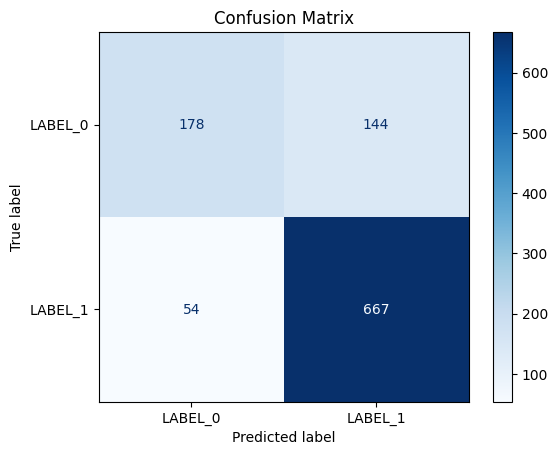

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")

# Add title and display
plt.title("Confusion Matrix")
plt.show()


**On training a custom enhanced distilbert model with additional layers, including pre-classification, hidden layers with batch normalization, and dropout regularization, an Accuracy of 0.81 was achieved along with an MCC of 0.53 and F1 score of 0.8**